# Predictions for Station QD6

This notebook is used to make predictions for station QD6. 

It includes model hyperparameter optimization, backtesting, and the execution of the prediction pipeline on the official test data.

In [ ]:
import sys
import os
# Add the parent directory to the Python path
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
)

In [80]:
# Import Libraries
import pandas as pd

import importlib
import utils
import modelsQD6

In [81]:
# In case of 'utils.py' modifications
importlib.reload(utils)

<module 'utils' from '/home/pedoussa/Bureau/PIR 5A _ 13-01-2026/QD6/utils.py'>

In [82]:
# In case of 'modelsQD6.py' modifications
importlib.reload(modelsQD6)

<module 'modelsQD6' from '/home/pedoussa/Bureau/PIR 5A _ 13-01-2026/QD6/modelsQD6.py'>

---

## 1: Prediction on 2022

### 1.1: Prepare Data

In [83]:
# Load Data
x_train = x_train = pd.read_csv('train_f_x.csv')
y_train = pd.read_csv('y_train_sncf.csv')
x_test = pd.read_csv('x_test.csv')

In [84]:
# Data Preparation
df = utils.prepare_backtest_data(x_train, y_train, remove_covid=True)

# Extract only QD6 station data
df_qd6 = df['QD6'].copy()
print("First Date with validations: ", df_qd6['date'].min())
print("Last Date with validations: ", df_qd6['date'].max())

# Split into train and test dataset
df_qd6_train, df_qd6_test = utils.split_dataset(df_qd6, cut_date='2022-09-17') # at 2/3 of data points available

First Date with validations:  2022-08-02 00:00:00
Last Date with validations:  2022-10-10 00:00:00


### 1.2: Predictions

#### 1.2.1: Hyperparameter Optimization

In [85]:
# imports
import optuna
import tqdm
from optuna.samplers import TPESampler

In [ ]:
def objectiveRNN(trial):
    """
    Optuna objective function to minimize the MAPE score for QD6 station.
    """
    # Define the search space for hyperparameters
    params = {
        "units": trial.suggest_int("units", 30, 60, step=5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [15, 20, 25, 30, 35, 40]),
        "seq_len": trial.suggest_int("seq_len", 10, 40, step=5)
    }

    # Initialize a fresh prediction DataFrame for this specific trial
    y_trial_placeholder = df_qd6_test[['index', 'y']].copy()

    try:
        # Call the backtest function with the suggested parameters
        _, _, qd6_mape_results = modelsQD6.backtest_prediction_QD6(
            df_per_station_train=df_qd6_train,
            df_per_station_test=df_qd6_test,
            y_predicted_vX=y_trial_placeholder,
            seq_len=params["seq_len"],
            units=params["units"],
            activation='tanh',
            learning_rate=params["learning_rate"],
            batch_size=params["batch_size"],
            epochs=100, 
            early_stop=True,
            architecture='rnn'
        )

        # Extract the MAPE score (index 0 because we only process QD6)
        current_mape = qd6_mape_results[0]['MAPE']
        
        # Return the score to Optuna (it will try to minimize this value)
        return current_mape

    except Exception as e:
        # If a specific combination of parameters fails (e.g., OOM or shape error), 
        # we return infinity so Optuna avoids this region.
        print(f"Trial failed with error: {e}")
        return float('inf')

In [ ]:
def objectiveLSTM(trial):
    """
    Optuna objective function to minimize the MAPE score for QD6 station.
    """
    # Define the search space for hyperparameters
    params = {
        "units": trial.suggest_int("units", 30, 60, step=5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [15, 20, 25, 30, 35, 40]),
        "seq_len": trial.suggest_int("seq_len", 10, 40, step=5)
    }

    # Initialize a fresh prediction DataFrame for this specific trial
    y_trial_placeholder = df_qd6_test[['index', 'y']].copy()

    try:
        # Call the backtest function with the suggested parameters
        _, _, qd6_mape_results = modelsQD6.backtest_prediction_QD6(
            df_per_station_train=df_qd6_train,
            df_per_station_test=df_qd6_test,
            y_predicted_vX=y_trial_placeholder,
            seq_len=params["seq_len"],
            units=params["units"],
            activation='tanh',
            learning_rate=params["learning_rate"],
            batch_size=params["batch_size"],
            epochs=100, 
            early_stop=True,
            architecture='lstm'
        )

        # Extract the MAPE score (index 0 because we only process QD6)
        current_mape = qd6_mape_results[0]['MAPE']
        
        # Return the score to Optuna (it will try to minimize this value)
        return current_mape

    except Exception as e:
        # If a specific combination of parameters fails (e.g., OOM or shape error), 
        # we return infinity so Optuna avoids this region.
        print(f"Trial failed with error: {e}")
        return float('inf')

In [88]:
# Run flag
run_flag = 0

In [ ]:
if (run_flag == 1):
    # Create and run the study
    studyRNN = optuna.create_study(direction="minimize")
    studyRNN.optimize(objectiveRNN, n_trials=30)
    print("Optimization Finished!")

    # Increment the run flag
    run_flag+=1

    # Display results
    print(f"Best MAPE: {studyRNN.best_value:.4f}")
    print("Best Hyperparameters for RNN:", studyRNN.best_params)

In [90]:
if (run_flag == 2):
    # Create and run the study
    studyLSTM = optuna.create_study(direction="minimize")
    studyLSTM.optimize(objectiveLSTM, n_trials=35)
    print("Optimization Finished!")

    # Increment the run flag
    run_flag+=1

    # Display results
    print(f"Best MAPE: {studyLSTM.best_value:.4f}")
    print("Best Hyperparameters for LSTM:", studyLSTM.best_params)

#### 1.2.2: Predictions

In [91]:
# Best Hyperparameters for RNN: {'units': 50, 'learning_rate': 0.0028305199375768288, 'batch_size': 20, 'seq_len': 10}
# Best MAPE: 0.0374
#
# Best Hyperparameters for LSTM: {'units': 45, 'learning_rate': 0.00040489918066348023, 'batch_size': 25, 'seq_len': 25}
# Best MAPE: 0.4748

In [92]:
# Parameters for RNN
units = 50
learning_rate = 0.0028305199375768288
batch_size = 20
seq_len = 10

activation = 'tanh'
epochs = 100

In [ ]:
# Create df to store the predictions
y_qd6_predicted_rnn = df_qd6_test[['index', 'date', 'y']].copy()
y_qd6_predicted_lstm = df_qd6_test[['index','date', 'y']].copy()

In [94]:
# Run RNN prediction pipeline
y_qd6_predicted_rnn, qd6_losses_rnn, qd6_mape_result_rnn = modelsQD6.backtest_prediction_QD6(df_qd6_train,
                                                             df_qd6_test,
                                                             y_qd6_predicted_rnn,
                                                             seq_len, units, activation, learning_rate, batch_size,
                                                             epochs, early_stop = True,
                                                             features = ['job', 'ferie', 'vacances'],
                                                             architecture = 'rnn')

Station QD6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


/home/pedoussa/Bureau/PIR 5A _ 13-01-2026/QD6/modelsQD6.py:144: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[171.42865  99.36198 234.00072 281.88437 273.7419  301.24356 225.48793
 171.42865  99.36198 234.00072 281.88437 273.7419  301.24356 225.48793
 171.42865  99.36198 234.00072 281.88437 273.7419  301.24356 225.48793
 171.42865  99.36198 234.00072]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_predicted_vX.loc[y_predicted_vX['index'].str.contains(name_station), 'y'] = y_pred


In [95]:
# Parameters for LSTM
units = 45
learning_rate = 0.00040489918066348023
batch_size = 25
seq_len = 25

activation = 'tanh'
epochs = 100

In [96]:
# Run LSTM prediction pipeline
y_qd6_predicted_lstm, qd6_losses_lstm, qd6_mape_result_lstm = modelsQD6.backtest_prediction_QD6(df_qd6_train,
                                                             df_qd6_test,
                                                             y_qd6_predicted_lstm,
                                                             seq_len, units, activation, learning_rate, batch_size,
                                                             epochs, early_stop = True,
                                                             features = ['job', 'ferie', 'vacances'],
                                                             architecture = 'lstm')

Station QD6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/home/pedoussa/Bureau/PIR 5A _ 13-01-2026/QD6/modelsQD6.py:144: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[146.59871 140.53961 132.1861  132.60352 134.88274 137.93721 141.02827
 143.57787 137.82124 129.81482 130.74164 133.4509  136.87215 140.28795
 143.13416 137.62427 129.81482 130.74164 133.4509  136.87215 140.28795
 143.13416 137.62427 129.81482]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_predicted_vX.loc[y_predicted_vX['index'].str.contains(name_station), 'y'] = y_pred


### 1.3: Explore Results

RNN Model
MAPE per station:
  station      MAPE
0     QD6  0.200644

Average MAPE over all stations: 0.2006

LSTM model
MAPE per station:
  station      MAPE
0     QD6  0.477391

Average MAPE over all stations: 0.4774


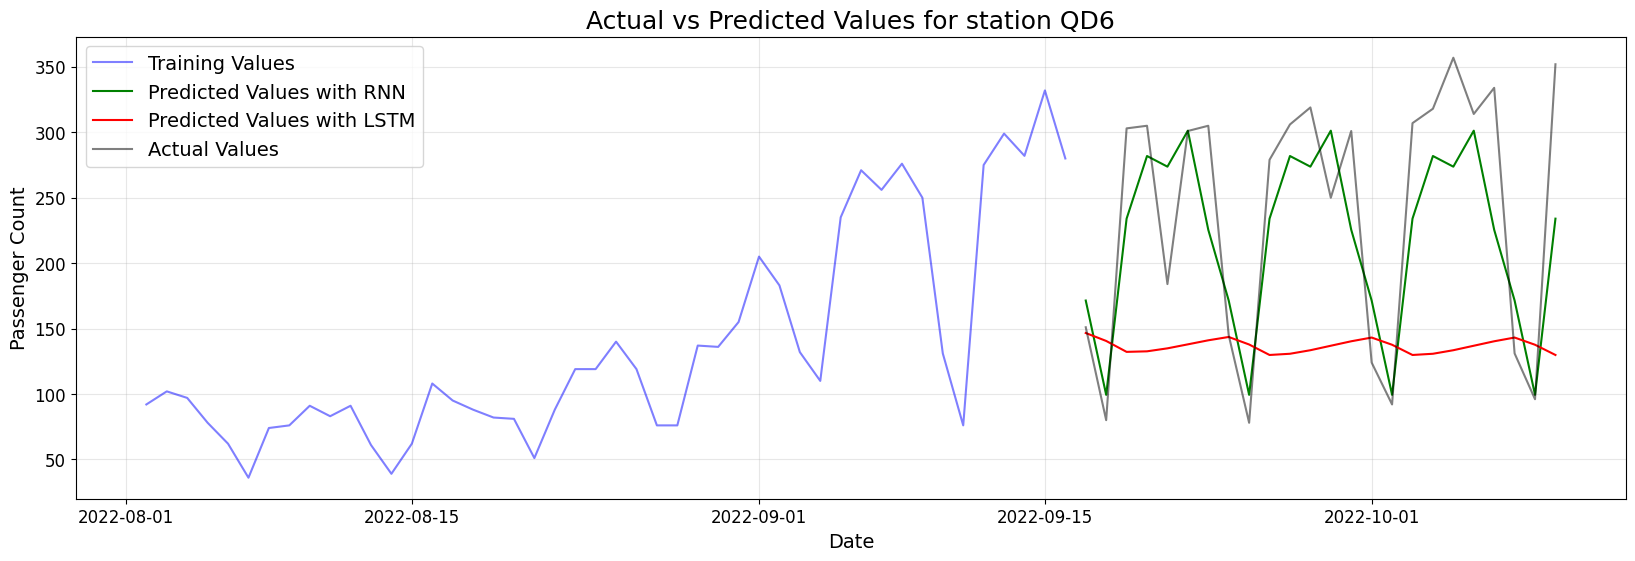

In [97]:
# Show MAPE results
print("RNN Model")
utils.show_mape_results(qd6_mape_result_rnn)
print(f"\nLSTM model")
utils.show_mape_results(qd6_mape_result_lstm)

# Show predictions
modelsQD6.show_predictions_two_results_one_station(df_qd6_train, y_qd6_predicted_rnn, y_qd6_predicted_lstm, df_qd6_test, 'QD6', 'RNN', 'LSTM')

## 2: Prediction on 2023

### 2.1: Prepare Data

In [98]:
# Load Data
x_train = x_train = pd.read_csv('train_f_x.csv')
y_train = pd.read_csv('y_train_sncf.csv')
x_test = pd.read_csv('x_test.csv')

In [99]:
# Prepare data
df_train, df_test = utils.prepare_submission_data(x_train, y_train, x_test, remove_covid=True)

# Extract only QD6 station data
df_qd6_train = df_train['QD6'].copy()
df_qd6_test = df_test['QD6'].copy()

print("First Date to predict: ", df_qd6_test['date'].min())
print("Last Date to predict: ", df_qd6_test['date'].max())

First Date to predict:  2023-04-26 00:00:00
Last Date to predict:  2023-06-12 00:00:00


In [ ]:
# Create a df to store the predictions
y_attempt = df_qd6_test[['index', 'date', 'y']].copy()

### 2.2: Predictions

In [101]:
# parameters
units = 50
learning_rate = 0.0028305199375768288
batch_size = 20
seq_len = 10

activation = 'tanh'
epochs = 50

In [102]:
# Run RNN prediction pipeline
y_predicted, qd6_losses = modelsQD6.submission_prediction_QD6(df_qd6_train, df_qd6_test, y_attempt,
                                                           seq_len, units, activation, learning_rate, batch_size,
                                                           epochs, early_stop = True,
                                                           features = ['job', 'ferie', 'vacances'],
                                                           architecture = 'rnn')

Station QD6
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


### 2.3: Explore Results

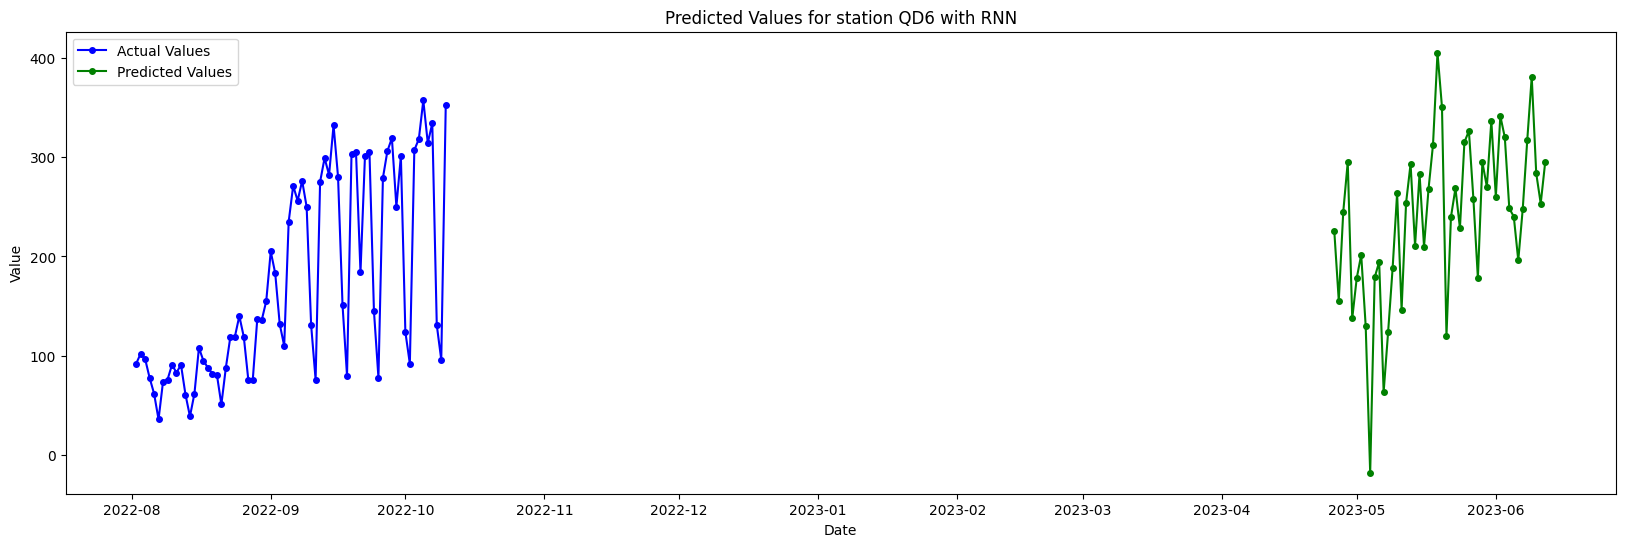

In [103]:
modelsQD6.show_prediction(df_qd6_train, y_predicted, 'QD6', 'RNN', start_date='2015-01-01')

In [104]:
# y_predicted.to_csv('QD6predictions.csv')

### 2.4: Extend prediction on [2023-01 -> 2023-04]

In [105]:
# Create the missing date range
missing_dates = pd.date_range(start="2023-01-01", end="2023-04-25", freq='D')

# Create a synthetic DataFrame for the missing period
df_missing = pd.DataFrame({
    'date': missing_dates,
    'station': 'QD6',
    'index': [d.strftime('%Y-%m-%d') + '_QD6' for d in missing_dates],
    'y': 0
})

# Add the features (job, ferie, vacances) for these dates
# Assuming x_test has the calendar info for those dates:
calendar_info = x_test[['date', 'job', 'ferie', 'vacances']].drop_duplicates()
df_missing = df_missing.merge(calendar_info, on='date', how='left')

# Concatenate with the actual test data
df_qd6_test_extended = pd.concat([df_missing, df_qd6_test]).sort_values('date').reset_index(drop=True)

# Create y_attempt_extended
y_attempt_extended = df_qd6_test_extended.copy()

In [106]:
# Run
y_predicted_extended, qd6_losses = modelsQD6.submission_prediction_QD6(df_qd6_train, df_qd6_test_extended, y_attempt_extended,
                                                           seq_len, units, activation, learning_rate, batch_size,
                                                           epochs, early_stop = True,
                                                           features = ['job', 'ferie', 'vacances'],
                                                           architecture = 'rnn')

Station QD6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


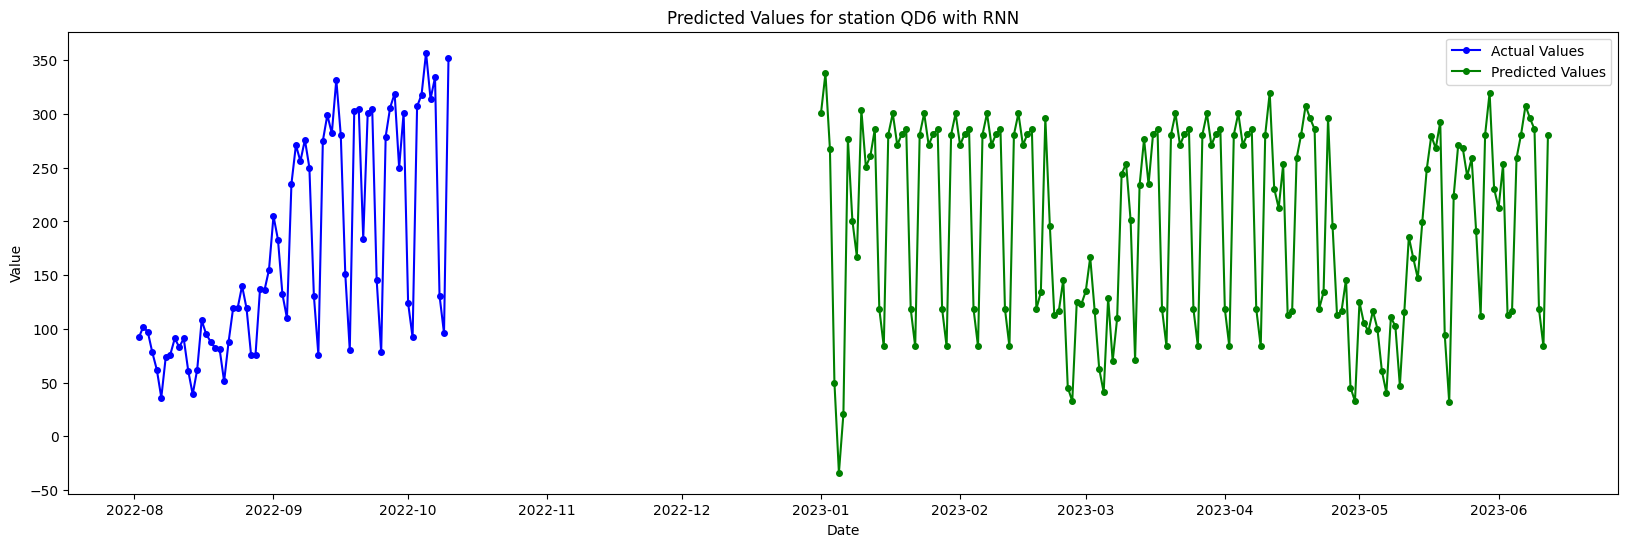

In [107]:
# Results
modelsQD6.show_prediction(df_qd6_train, y_predicted_extended, 'QD6', 'RNN', start_date='2015-01-01')